In [1]:
import pandas as pd
import sqlite3 as sq
import surprise

In [14]:
#Set up data
path = '/Users/Dustin/GT_project/test2.db'
def import_data(db_path):
    conn = sq.connect(db_path) #sqliteDB path goes in parantheses
    crsr = conn.cursor()

    df = pd.read_sql_query('''
                SELECT
                    customer_id,
                    product_id,
                    product_parent,
                    star_rating,
                    helpful_votes,
                    review_headline,
                    review_body,
                    product_category,
                    marketplace,
                    review_date,
                    verified_purchase
                FROM books
                WHERE star_rating IN (
                                    SELECT star_rating
                                    FROM books
                                    GROUP BY customer_id
                                    HAVING COUNT(star_rating)>=58
                                    )
                AND STAR_RATING IN (
                                    SELECT star_rating
                                    FROM books
                                    GROUP BY product_id
                                    HAVING COUNT(star_rating)>32
                                    );
                ''', conn)

    df['star_rating'] = df['star_rating'].astype(float)
    df['star_rating'] = df['star_rating'].astype(int) #convert rating to integer type
    df['helpful_votes'] = df['helpful_votes'].astype(int) #convert rating to integer type

    df['review_body'] = df['review_body'].astype(str) #convert to str
    df['review_headline'] = df['review_headline'].astype(str) #convert to str
    

    return df

df = import_data(path)

In [15]:
df.head(5)
#len(df)
#df.dtypes

,customer_id,product_id,product_parent,star_rating,helpful_votes,review_headline,review_body,product_category,marketplace,review_date,verified_purchase
0,25933450,0439873800,84656342,5,0,Five Stars,I love it and so does my students!,Books,US,2015-08-31,Y
1,1801372,1623953553,729938122,5,0,"Please buy ""I Saw a Friend""! Your children wil...",My wife and I ordered 2 books and gave them as...,Books,US,2015-08-31,Y
2,5782091,142151981X,678139048,5,0,Shipped fast.,Great book just like all the others in the ser...,Books,US,2015-08-31,Y
3,32715830,014241543X,712432151,5,0,Five Stars,So beautiful,Books,US,2015-08-31,N
4,14005703,1604600527,800572372,5,2,Five Stars,Enjoyed the author's story and his quilts are ...,Books,US,2015-08-31,Y


In [4]:
def count_words(data):
   words = data.split(" ")
   num_words = len(words)
   return num_words

df['review_word_count']=0
df['review_hl_count']=0

df['review_word_count'] = df['review_body'].map(count_words)
df['review_hl_count'] = df['review_headline'].map(count_words)


In [5]:
X_dat = df[['product_parent','star_rating','helpful_votes','review_word_count','review_hl_count']]



In [6]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X_dat)
visualizer.poof()

/anaconda3/lib/python3.6/site-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<Figure size 800x550 with 2 Axes>

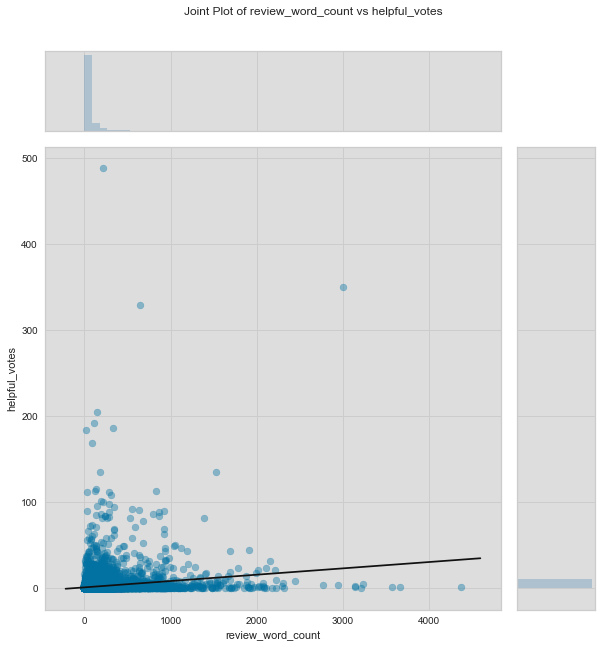

In [7]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='review_word_count', target='helpful_votes')
visualizer.fit(X_dat['review_word_count'], X_dat['helpful_votes'])
visualizer.poof()

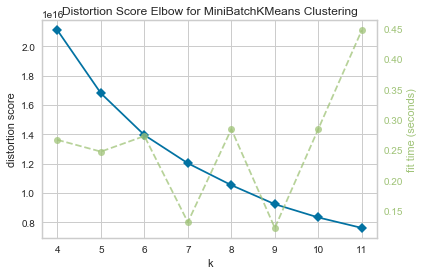

In [8]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(4,12))

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

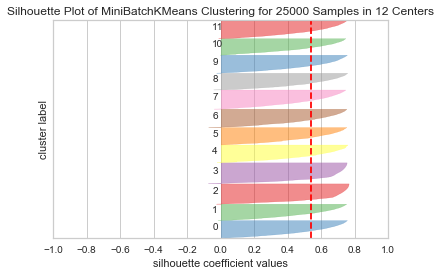

In [9]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(12)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [9]:
from surprise import Reader, Dataset

# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

ratings_dict = {'itemID': list(df.product_id),
                'userID': list(df.customer_id),
                'rating': list(df.star_rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)


In [10]:
###Using Suprise package
# Split data into 5 folds

data.split(n_folds=5)

from surprise import SVD, evaluate
from surprise import NMF, model_selection

# svd
algo = SVD()
model_selection.cross_validate(algo, data, measures=['RMSE'])




{'test_rmse': array([0.02271591, 0.02240481, 0.02221683, 0.02405772, 0.02203121]),
 'fit_time': (4.1763880252838135,
  4.115966081619263,
  4.697727918624878,
  4.241499900817871,
  4.361199855804443),
 'test_time': (0.10476016998291016,
  0.10020303726196289,
  0.11382603645324707,
  0.1009969711303711,
  0.10503983497619629)}

In [ ]:
# nmf
algo = NMF()
nmf_mod = model_selection.cross_validate(algo, data, measures=['RMSE'])
nmf_mod.fit()

In [ ]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations